# Unsupervised anomaly detection with Temporian and scikit-learn

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/last-release/docs/src/tutorials/anomaly_detection_unsupervised.ipynb)

In this tutorial, we use Temporian and Scikit-Learn to detect anomalies in a multivariate time series dataset.

Anomaly detection in time series, time sequences and other temporal formats is critical in a variety of domains. For instance, it is used in manufacturing to detect equipment failure and production lines, in computer systems and by financial institutions to detect fraudulent activities, and in energy management to detect outages.

We will use the Server Machine Dataset (SMD) dataset, published as part of the [OmniAnomaly](https://github.com/NetManAIOps/OmniAnomaly/) paper, which is available in CSV files in that same repository.

This dataset contains aggregated resource usage metrics (e.g., CPU and RAM utilization, network traffic) from 28 computers in 3 data centers over a period of 5 weeks. The timestamps and feature names have been anonymized and normalized. Therefore, calendar feature engineering or the use of expert knowledge is not possible.

The dataset will be loaded, feature engineered and converted into a tabular dataset using Temporian. Then, we will use an isolation forest model on this tabular data to detect anomalies. Finally, we will evaluate the quality of our detection on the ground truth anomalies, available as part of the testing dataset.

We will first evaluate our detections both with AUC-[ROCs](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (Area Under the Receiver operating Characteristic curve) and with [AMOCs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2815453/) (Activity Monitoring Operating Characteristic). Unlike an ROC, an AMOC takes into account the *time to detection* or *forecasting horizon* which is often critical in temporal problems like ours. If you don't know about AMOCs yet, don't worry. We will explain it.

Check out the [Supervised anomaly detection](https://temporian.readthedocs.io/en/stable/tutorials/anomaly_detection_supervised/) tutorial for a version of this notebook that trains a supervised model using the ground truth labels, which is less common in an anomaly detection setting, but can yield better performance if those are available.

## Installation and imports

In [2]:
%pip install temporian -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import urllib.request

import temporian as tp

## Download dataset

The dataset is made of 3 groups of 8, 9, and 11 machines respectively, with names `"machine-1-1"`, ..., `"machine-3-11"`.
Let's list the machine names, and download records locally.

**Note:** For this notebook to run quickly, we only use three machines. To run it on all the machines, swap the commented line below.

In [4]:
machines_per_group = [2, 1, 0] # Only 3 machines
# machines_per_group = [8, 9, 11] # Full dataset

machines = [f"machine-{group}-{id}" for group, machine in zip(range(1, 4), machines_per_group) for id in range(1, machine + 1)]
machines

['machine-1-1', 'machine-1-2', 'machine-2-1']

In [5]:
data_dir = Path("tmp/temporian_server_machine_dataset")
dataset_url = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset"

data_dir.mkdir(parents=True, exist_ok=True)

# Download the data and labels for each machine to its own folder
for machine in machines:
    print(f"Download data of {machine}")
    
    machine_dir = data_dir / machine
    machine_dir.mkdir(exist_ok=True)
    
    data_path = machine_dir / "data.csv"
    if not data_path.exists():
        urllib.request.urlretrieve(f"{dataset_url}/test/{machine}.txt", data_path)

    labels_path = machine_dir / "labels.csv"
    if not labels_path.exists():
         urllib.request.urlretrieve(f"{dataset_url}/test_label/{machine}.txt", labels_path)

Download data of machine-1-1
Download data of machine-1-2
Download data of machine-2-1


## Load data

We use Pandas to load the data into a `DataFrame` and perform tabular manipulation before importing it into a Temporian as an `EventSet`.

We index the data by the `machine` column in Temporian. This was, we can apply Temporian transformations on each machine individually as well as across all machines.

In [6]:
dataframes = []

for machine in machines:
    machine_dir = data_dir / machine

    # Read the data and labels
    print(f"Import {machine}")
    df = pd.read_csv(machine_dir / "data.csv", header=None).add_prefix("f")
    labels = pd.read_csv(machine_dir/ "labels.csv", header=None)
    df = df.assign(label=labels)
    df["machine"] = machine
    df["timestamp"] = range(df.shape[0])
    print(f"\tFound {df.shape[0]} events")
    
    dataframes.append(df)

dataframes[0].head(3)

Import machine-1-1
	Found 28479 events
Import machine-1-2
	Found 23694 events
Import machine-2-1
	Found 23694 events


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f31,f32,f33,f34,f35,f36,f37,label,machine,timestamp
0,0.075269,0.065678,0.070234,0.074332,0.0,0.933333,0.274011,0.0,0.031081,0.000000,...,0.048893,0.000386,0.000034,0.064432,0.064500,0.0,0.0,0,machine-1-1,0
1,0.086022,0.080508,0.075808,0.076655,0.0,0.930769,0.274953,0.0,0.031081,0.000122,...,0.050437,0.000386,0.000022,0.065228,0.065224,0.0,0.0,0,machine-1-1,1
2,0.075269,0.064619,0.071349,0.074332,0.0,0.928205,0.274953,0.0,0.030940,0.000366,...,0.055069,0.000386,0.000045,0.067111,0.067178,0.0,0.0,0,machine-1-1,2


In [7]:
# Convert the dataframes into a single Temporian EventSet

evset = tp.combine(*map(tp.from_pandas, dataframes))

# Index the EventSet according the the machine name.
evset = evset.set_index("machine")

# Cast the feature and label to a smaller dtypes to same one memory.
evset = evset.cast(tp.float32).cast({"label": tp.int32})

evset

timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.23,0.1095,0.1266,0.1338,0.2264,0.621,0.4093,0,9.3e-05,1.5e-05,0,0.00722,0,0.03695,0.003551,0.02929,…
1,0.25,0.1089,0.1271,0.134,0.2264,0.5473,0.337,0,9.3e-05,1.5e-05,0,0.009025,0,0.03926,0.004129,0.03305,…
2,0.24,0.1228,0.1308,0.1353,0.2264,0.4785,0.2648,0,0.000653,0.000134,8e-06,0.01805,0,0.09858,0.009166,0.09242,…


Awesome! Seems like each machine has more than 20.000 events and 39 features (counting the "label" one).

As stated previously, all metrics seem to be anonymized and normalized to `[0, 1]`, so we won't need to take care of that ourselves.

## Data visualization

Let's take a look at some of the first machine's features.

The number of plots (39) is larger than "options.max_num_plots=3". Only the first plots will be printed.


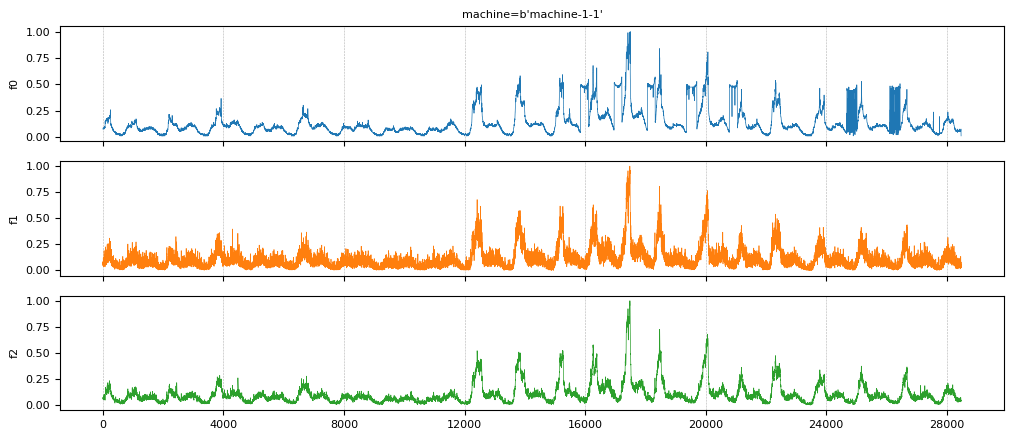

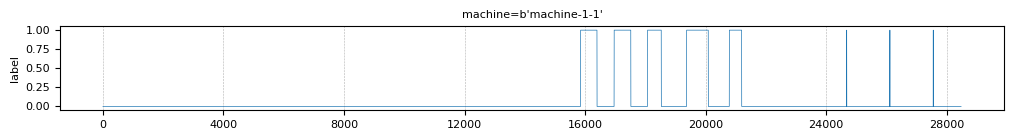

In [78]:
# Plot the first 3 features
evset.plot(indexes="machine-1-1", max_num_plots=3)

# Plot the labels
evset["label"].plot(indexes="machine-1-1")

Great! A lot to unpack here:
- It seems to be easy to understand when an anomaly occurs (label takes value of 1) by looking at the other plots. Features 11 to 14, for example, seem to be very correlated to the label.
- The data seems to have some periodicity to it.
- Some features seem empty, and we could evaluate dropping them if needed.

## Data preparation

To prepare our data to train a model on it, let's start off by separating the features from the labels.

In [79]:
feature_names = evset.schema.feature_names()
feature_names.remove("label")

raw_features = evset[feature_names]
labels = evset["label"]

print("Raw features:", raw_features.schema)
print("Labels:", labels.schema)

Raw features: features: [('f0', float32), ('f1', float32), ('f2', float32), ('f3', float32), ('f4', float32), ('f5', float32), ('f6', float32), ('f7', float32), ('f8', float32), ('f9', float32), ('f10', float32), ('f11', float32), ('f12', float32), ('f13', float32), ('f14', float32), ('f15', float32), ('f16', float32), ('f17', float32), ('f18', float32), ('f19', float32), ('f20', float32), ('f21', float32), ('f22', float32), ('f23', float32), ('f24', float32), ('f25', float32), ('f26', float32), ('f27', float32), ('f28', float32), ('f29', float32), ('f30', float32), ('f31', float32), ('f32', float32), ('f33', float32), ('f34', float32), ('f35', float32), ('f36', float32), ('f37', float32)]
indexes: [('machine', str_)]
is_unix_timestamp: False

Labels: features: [('label', int32)]
indexes: [('machine', str_)]
is_unix_timestamp: False



Next, we'll need to split our dataset into train and testing sets, which we'll use an 80/20 split for.

Note that the train labels will only be used for evaluation purposes.

We'll be creating reusable functions for each step, since we'll do some iteration over the `feature engineering -> training -> evaluation` cycle.

In [80]:
DROP_COLS = ["machine", "timestamp"]

def split_event_set(evset: tp.EventSet, test_frac: float = 0.2):

    # Average length of the records
    average_duration = np.mean([len(machine_data.timestamps) for _, machine_data in evset.data.items()])
    print("average_duration:", average_duration)

    # Select the train/test cutoff.
    # Note: All the machines are cut at the same time. This way, we can apply pre-processing that
    # exchange data between the machines without risk of label leakage!
    train_cutoff = average_duration * (1 - test_frac)
    print("train_cutoff:", train_cutoff)

    # Compute masks and split data based on cutoff
    train_mask = evset.timestamps() <= int(train_cutoff)
    test_mask = ~train_mask

    # Split EventSets
    train_evset = evset.filter(train_mask)
    test_evset = evset.filter(test_mask)

    print(f"Train events: {train_evset.num_events()}")
    print(f"Test events: {test_evset.num_events()}")

    return train_evset, test_evset

def evsets_to_tabular(*evsets: tp.EventSet) -> List[np.ndarray]:
    datasets = []
    for evset in evsets:
        # Fill missing values with -1 (raw data doesn't have any, but we will create some in our feature engineering)
        df = tp.to_pandas(evset).fillna(-1)
        
        # Remove timestamp and machine columns
        df = df.drop(columns=DROP_COLS)

        # Convert to numpy (and convert from 2D to 1D array if it has a single feature, in the case of the labels)
        arr = df.to_numpy().squeeze()
        
        datasets.append(arr)
        
    return datasets

features_train, features_test = split_event_set(raw_features)
labels_train, labels_test = split_event_set(labels)  # Note that we won't be using the train labels for training in this unsupervised setting

X_train, X_test, y_train, y_test = evsets_to_tabular(features_train, features_test, labels_train, labels_test)

average_duration: 25289.0
train_cutoff: 20231.2
Train events: 60696
Test events: 15171
average_duration: 25289.0
train_cutoff: 20231.2
Train events: 60696
Test events: 15171


## Training

Having done all that work to prepare our data, all that remains is to train our model.

In [81]:
contamination = y_train.sum() / len(y_train)
print(f"{contamination=}")

def train(X_train):
    model = IsolationForest(
        contamination=contamination,
        n_jobs=-1,
        verbose=1,
        random_state=0,
    )
    model.fit(X_train)
    return model

contamination=0.05665941742454198


In [82]:
model = train(X_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


## Evaluation using AUC-ROC

We'll be reporting the model's ROC AUC score, which provides an aggregate measure of performance across all possible classification thresholds (since our model outputs an anomaly score for each sample, and in a real-world scenario it would be up to us to define the thershold from which we consider an event to be marked as anomalous).

In [83]:
figsize=(20,3)

results = {}

def evaluate(model, X_test, y_test, name):
    """Evaluates a model on its training data and unseen test data, computing accuracy score and plotting ground truth vs predictions."""
    # Compute and print scores
    roc_auc = roc_auc_score(y_test, -model.score_samples(X_test))
    
    results[name] = {"ROC AUC": roc_auc}
    
    print("Results:")
    print(pd.DataFrame(results))

    # Plot predictions
    preds = model.predict(X_test)
    preds[preds == 1] = 0
    preds[preds == -1] = 1
    tp.event_set(timestamps=list(range(len(y_test))), features={"labels": y_test, "predictions": preds}).plot(style="vline")

Results:
         raw features
ROC AUC      0.850906


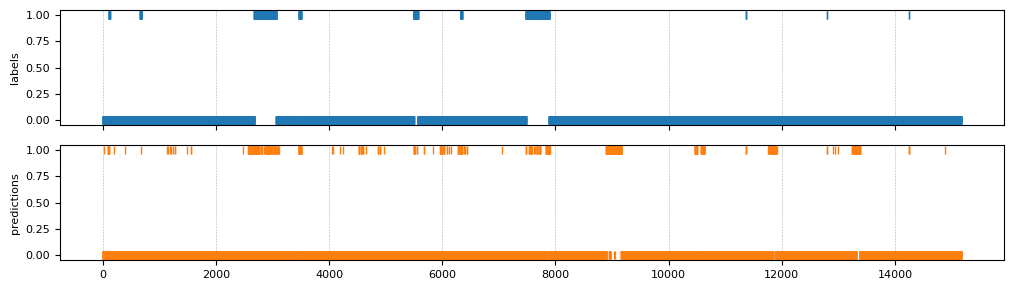

In [84]:
evaluate(model, X_test, y_test, "raw features")

That's pretty decent for a first try! Our model seems to be learning.

The plotted predictions seem to be all over the place though, with the model sporadically predicting anomaly events throughout in several non-anomalous periods.

There's plenty of room for improvement, so let's kick off the feature engineering!

## Evaluation using AMOC

An AMOC measure the relation between false alerts (or average time between false alerts) and the average time to detection.
Using Temporian, it is easy to implement an AMOC.

Here is how an AMOC is computed.

We want to detect "anomalies" events. In our dataset, we generate an anomaly event each time the "label" (or "target") is true.
Our model creates a numerical detection "signal". Like for an AUC, we evaluate our model with different threshold values applied on the signal.
An "alert" event is generated each time the "signal" goes over the detection threshold.


A "false alert" is an alert that does not detect an anomaly event i.e. an alert a`t` time t without any anom`aly in [t-abnomaly_win`dow, t].
A "missed anomaly" is an anomaly that is not detected by any alert i.e. an anomaly `a`t time t without any a`lert in [t, t+abnomaly`_window].
The "time to detection" of an anomaly` `at time t is the time between the anomaly and the first following `alert in [t, t+abnomal`y_window]. If there is not alert in this time window, the "time to detection" is assumed to be abnomaly_window.

In practice, two anomalies that happen next to each other in time can be considered the same anomaly. So we apply a "shutoff" on the anomalies:
Two anomalies cannot happen within "missed_target_shutoff" of each other.
Similarly, we apply a "shutoff" on the false alerts.

Here is a diagram to summarise

![](https://raw.githubusercontent.com/google/temporian/main/docs/src/assets/amoc.svg)

An AMOC can be computed on any signal, not just a model output. Let's compute the AMOC on the features `f1` and `f2`.
We can find which one of the two features alone can best detect anomalies.he situation:



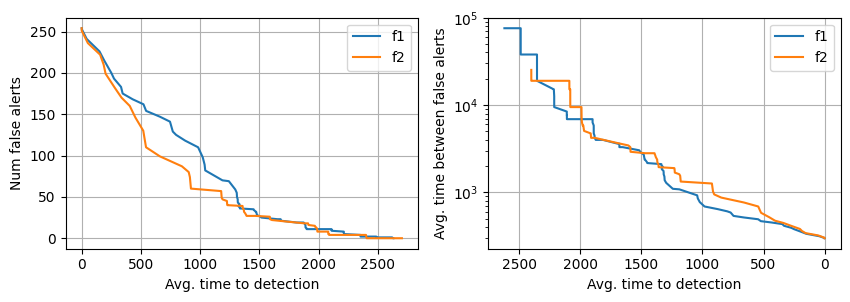

In [85]:
from dataclasses import dataclass
from typing import Optional, Dict, List
import matplotlib.pyplot as plt

@dataclass
class ThresholdEval:
    """Model metric for each threshold value applied on the score."""
    
    threshold: float
    num_false_alerts: int
    num_missed_targets: int
    average_time_to_detection: float
    total_record_duration: float

# TODO: Add AMOC in Temporian
def compute_detection_amoc(target : tp.EventSet,
                   signal : tp.EventSet,
                   detection_thresholds: List[float] = np.linspace(0,1,100, dtype=np.float32).tolist(),
                   abnomaly_window : float = 1000.,
                   abnomaly_shutoff : float = 200.,
                   false_alert_shutoff : float = 200.,
                  ) -> List[ThresholdEval]:
    """Computes a detection AMOC.

    Args:
        target: A boolean feature defining an abnomaly to detect.
        signal: A numerical feature detecting recent abnomalies. A signal above a threshold becomes an alert. 
        detection_thresholds: List of evaluated detection thresholds applied on the "signal".
        abnomaly_window: For how long an abnomaly can be detected.
        abnomaly_shutoff: Minimum distance between two abnomalies.
        false_alert_shutoff: Minimum distance between two missed alerts.
    """

    # List the anomalies
    abnomalies = target.cast(tp.bool_).filter()
    abnomalies = abnomalies.filter_moving_count(abnomaly_shutoff)

    # Final timestamp used to collect all the metrics.
    end_of_records = signal.end()
    end_of_records_global = end_of_records.drop_index(keep=False).end()

    def sum_by_index(evtset) -> int:
        """Sums and returns the last value of a feature in all the indexes."""
        assert len(evtset.schema.features) == 1
        return float(evtset.drop_index(keep=False).cumsum(sampling=end_of_records_global).get_arbitrary_index_data().features[0][0])

    # The duration of record in each index is the time distance between the first and last event.
    record_duration = signal.begin().since_last(sampling=signal.end())
    total_record_duration = sum_by_index(record_duration)

    amoc = []

    for threshold in detection_thresholds:
        alerts = (signal >= threshold).filter()

        # False alerts
        false_alerts = tp.equal_scalar(abnomalies.moving_count(abnomaly_window, sampling=alerts), 0).filter()
        false_alerts = false_alerts.filter_moving_count(false_alert_shutoff)
        num_false_alerts = false_alerts.moving_count(np.inf, sampling=end_of_records)

        # Missed targets
        missed_abnomalies = tp.equal_scalar(alerts.moving_count(abnomaly_window, sampling=abnomalies.lag(abnomaly_window)), 0).filter().leak(abnomaly_window)
        missed_abnomalies = missed_abnomalies.filter_moving_count(false_alert_shutoff)
        num_missed_targets = missed_abnomalies.moving_count(np.inf, sampling=end_of_records)

        # Time to detection
        time_to_detection = abnomalies.until_next(sampling=alerts, timeout=abnomaly_window)
        # Set the time to detection of non detected abnomalies with the maximum abnomaly_window.
        time_to_detection = tp.isnan(time_to_detection).where(abnomaly_window, time_to_detection)
        average_time_to_detection = time_to_detection.simple_moving_average(np.inf, sampling=end_of_records)

        amoc.append(ThresholdEval(
            threshold=threshold,
            num_false_alerts=sum_by_index(num_false_alerts),
            num_missed_targets=sum_by_index(num_missed_targets),
            average_time_to_detection=sum_by_index(average_time_to_detection),
            total_record_duration=total_record_duration,
        ))

    return amoc

def plot_detection_amoc(amoc_dict: Dict[str, List[ThresholdEval]]):
    
    # Plot the AMOC and other related plots
    fig, axs = plt.subplots(1, 2, figsize=(5*2, 3), squeeze=False)

    for name, amoc in amoc_dict.items():
        ax = axs[0,0]
        ax.plot([e.average_time_to_detection for e in amoc],
                [e.num_false_alerts for e in amoc],
               label=name)
    
        ax = axs[0,1]
        ax.plot([e.average_time_to_detection for e in amoc if e.num_false_alerts != 0],
                [e.total_record_duration / e.num_false_alerts for e in amoc if e.num_false_alerts != 0],
               label=name)

    ax = axs[0,0]
    ax.set_xlabel("Avg. time to detection")
    ax.set_ylabel("Num false alerts")
    ax.legend()
    ax.grid(True)

    ax = axs[0,1]
    ax.set_xlabel("Avg. time to detection")
    ax.set_ylabel("Avg. time between false alerts")
    ax.set_yscale("log")
    ax.invert_xaxis()
    ax.legend()
    ax.grid(True)

amoc_f1 = compute_detection_amoc(evset["label"], evset["f1"])
amoc_f2 = compute_detection_amoc(evset["label"], evset["f2"])

plot_detection_amoc({
    "f1":amoc_f1,
    "f2":amoc_f2,
})

We can see that `f2` is slighly better than `f1`. For instance, with an average time to detection of 1000 time-units, `f1` generates ~100 false alerts while `f2` generates ~60 false alerts.

What about our detection model now?

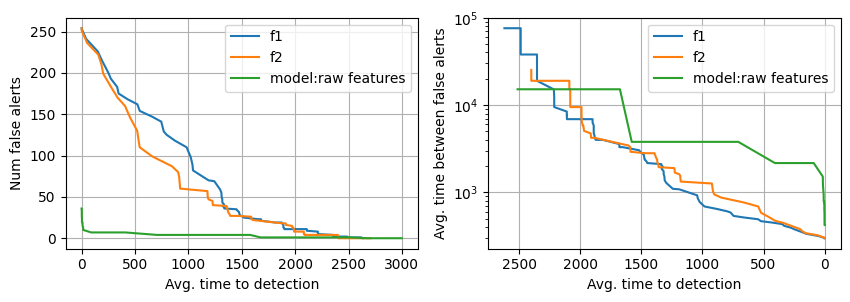

In [86]:
def model_prediction_to_evtset(model):
    df = tp.to_pandas(features_test)[["machine", "timestamp"]]
    df["detection"] = -model.score_samples(X_test)
    df["label"] = y_test
    evtset = tp.from_pandas(df).add_index("machine")
    return evtset

pred_evtset = model_prediction_to_evtset(model)
amoc_model_raw_features = compute_detection_amoc(pred_evtset["label"], pred_evtset["detection"])

plot_detection_amoc({
    "f1":amoc_f1,
    "f2":amoc_f2,
    "model:raw features": amoc_model_raw_features,
})

The model is **much** better than the features alone. This is expected, but it is a good check to do :).

## Feature engineering

### Lag features

Right now our model only has access to each event's raw metric values, + the group and machine that it belongs to. This means that it has no knowledge of the **context** an event is happening on - some values might have been completely normal when the measuring started, but anomalous a couple of weeks later, e.g. if that machine's usage went up as a whole during that time and its baseline usage now stands much higher than it used to.

To combat this, we'll start by lagging the values of each feature. In doing this, we're providing the model (some) information about that the metric's value looked like a couple of steps into the past.

In [87]:
lag_features = []

# Lag each raw feature by 1, 2, ..., 10 steps
for window in range(1, 11):
    lag_features.append(raw_features.lag(window).resample(raw_features).prefix(f"lag_{window}_"))

features = tp.glue(raw_features, *lag_features)
features

timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.23,0.1095,0.1266,0.1338,0.2264,0.621,0.4093,0,9.3e-05,1.5e-05,0,0.00722,0,0.03695,0.003551,0.02929,…
1,0.25,0.1089,0.1271,0.134,0.2264,0.5473,0.337,0,9.3e-05,1.5e-05,0,0.009025,0,0.03926,0.004129,0.03305,…
2,0.24,0.1228,0.1308,0.1353,0.2264,0.4785,0.2648,0,0.000653,0.000134,8e-06,0.01805,0,0.09858,0.009166,0.09242,…


Let's take a look at any metric alongside its lagged values. We'll select a small time window, to be able to appreciate how the time series moves to the right as the number of lagged timesteps increases.

The number of plots (33) is larger than "options.max_num_plots=4". Only the first plots will be printed.


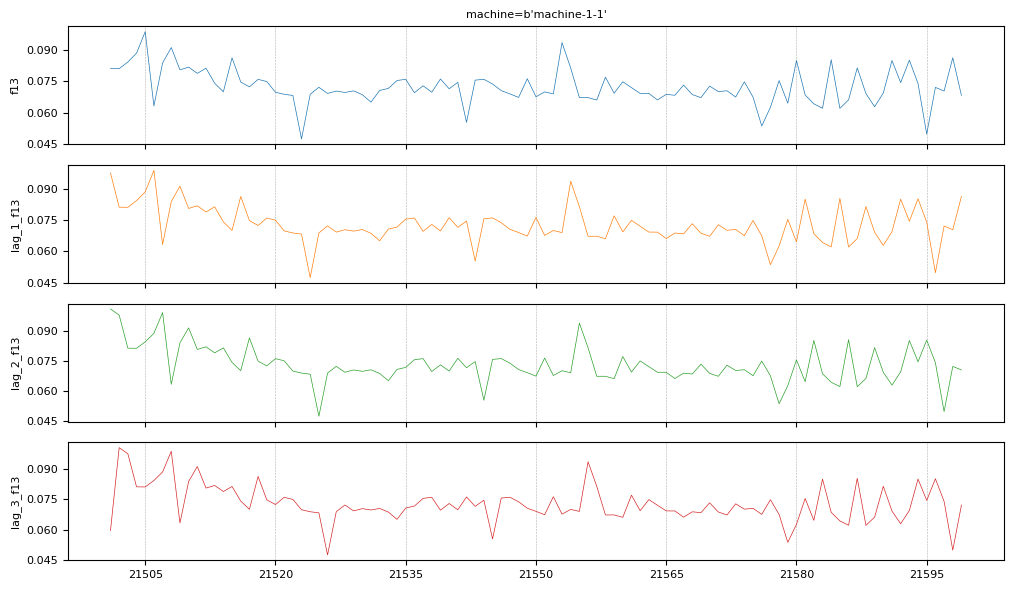

In [88]:
f13_lags = features[["f13"] + [f"lag_{i}_f13" for i in range(1, 11)]]
timestamps = f13_lags.timestamps()
f13_lags = f13_lags.filter((timestamps > 21500) & (timestamps < 21600))
f13_lags.plot(max_num_plots=4)

Time to train and evaluate a new model with these new features! 

average_duration: 25289.0
train_cutoff: 20231.2
Train events: 60696
Test events: 15171
average_duration: 25289.0
train_cutoff: 20231.2
Train events: 60696
Test events: 15171


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


Results:
         raw features  lagged features
ROC AUC      0.850906         0.877845


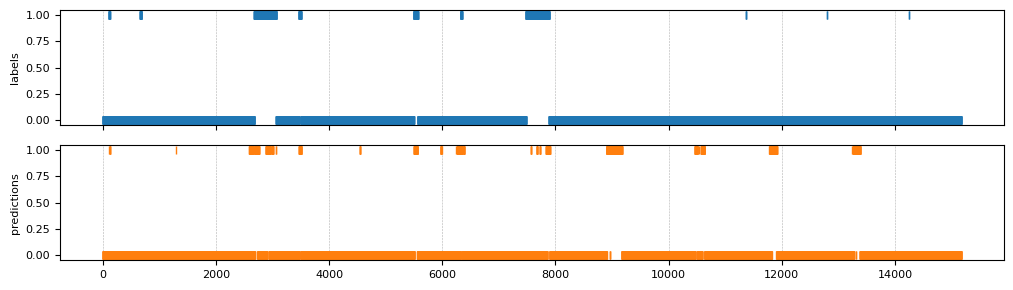

In [89]:
features_train, features_test = split_event_set(features)
_, labels_test = split_event_set(labels)

X_train, X_test, y_test = evsets_to_tabular(features_train, features_test, labels_test)

model = train(X_train)
evaluate(model, X_test, y_test, "lagged features")

Nice! The lagged features seem to have helped the model quite a bit. The ROC AUC went up, and the predictions are already looking more solid, with several anomalous periods being correctly identified.

What about the AMOC?

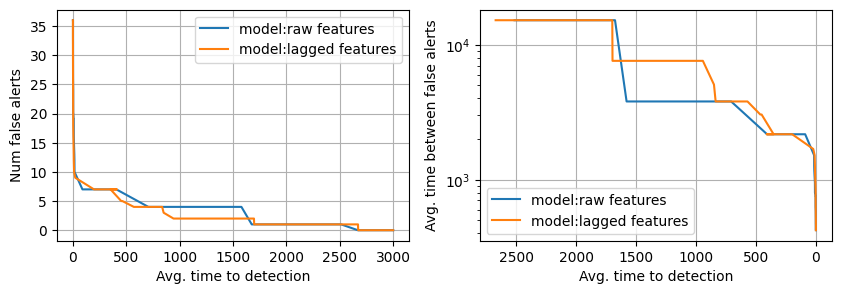

In [90]:
pred_evtset = model_prediction_to_evtset(model)
amoc_model_lagged_features = compute_detection_amoc(pred_evtset["label"], pred_evtset["detection"])

plot_detection_amoc({
    "model:raw features": amoc_model_raw_features,
    "model:lagged features": amoc_model_lagged_features,
})

As with the AUC, we see that the model with lagged features is a bit better than the model with raw features.

### Moving statistic features

Although useful, the raw lagged values aren't enough to provide the model a comprehensive look at each value's past context. Note also that we only gave it a glimpse of 10 steps into the past, and each time series has more than 23k values.

This is where **moving statistics** can come in handy. Instead of a list of raw values, we can provide the model an aggregation of each metric's values over the last N timesteps. For example, we can tell it what the maximum and minimum value of a metric were in the last 20 steps, or what the standard deviation was in the last 1000. 

Luckily, Temporian's window operators make this a breeze.

In [91]:
moving_statistic_features = []

# Compute the moving average, standard deviation, max, and min over different windows
for window in [20, 200, 2000]:
    moving_statistic_features.append(raw_features.simple_moving_average(window).prefix(f"avg_{window}_"))
    moving_statistic_features.append(raw_features.moving_standard_deviation(window).prefix(f"std_{window}_"))
    moving_statistic_features.append(raw_features.moving_max(window).prefix(f"max_{window}_"))
    moving_statistic_features.append(raw_features.moving_min(window).prefix(f"min_{window}_"))

features = tp.glue(raw_features, *lag_features, *moving_statistic_features)
features

timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.07527,0.06568,0.07023,0.07433,0,0.9333,0.274,0,0.03108,0,0.1341,0.08108,0.0274,0.06781,0.1258,0.1506,…
1,0.08602,0.08051,0.07581,0.07666,0,0.9308,0.275,0,0.03108,0.000122,0.1488,0.1622,0.0548,0.0714,0.1231,0.1645,…
2,0.07527,0.06462,0.07135,0.07433,0,0.9282,0.275,0,0.03094,0.000366,0.1348,0.0946,0.0274,0.06328,0.129,0.1515,…
3,0.08602,0.04873,0.06355,0.07085,0,0.9282,0.2731,0,0.02725,0.000244,0.1313,0.08108,0.0274,0.06784,0.1104,0.1456,…
4,0.08602,0.05191,0.06243,0.07085,0,0.9333,0.274,0,0.03094,0.000244,0.1027,0.1081,0.0411,0.07565,0.1191,0.1184,…
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
timestamp,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,…
0,0.23,0.1095,0.1266,0.1338,0.2264,0.621,0.4093,0,9.3e-05,1.5e-05,0,0.00722,0,0.03695,0.003551,0.02929,…
1,0.25,0.1089,0.1271,0.134,0.2264,0.5473,0.337,0,9.3e-05,1.5e-05,0,0.009025,0,0.03926,0.004129,0.03305,…
2,0.24,0.1228,0.1308,0.1353,0.2264,0.4785,0.2648,0,0.000653,0.000134,8e-06,0.01805,0,0.09858,0.009166,0.09242,…


Taking a look at some of the generated features:

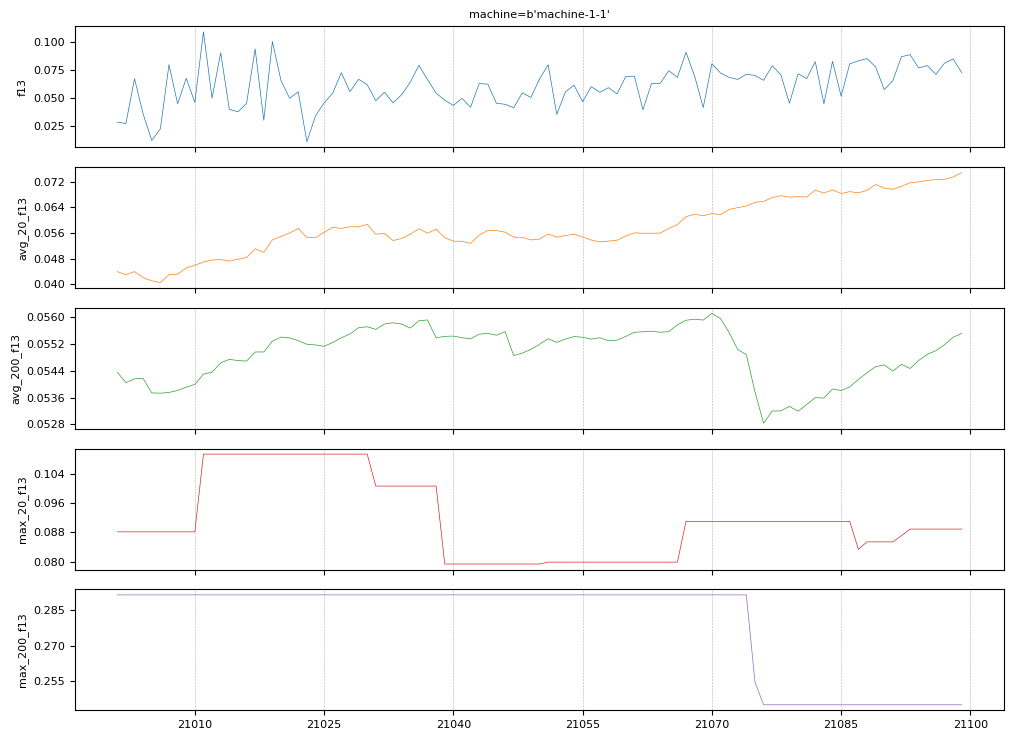

In [92]:
f13_stats = features[["f13", "avg_20_f13", "avg_200_f13", "max_20_f13", "max_200_f13"]]
timestamps = f13_stats.timestamps()
f13_stats = f13_stats.filter((timestamps > 21000) & (timestamps < 21100))
f13_stats.plot(indexes="machine-1-1")

Moving statistics can be a good indicator of what a sequence's "normal" behavior looks like. 

As an example, `"avg_20_f12"`'s plot shows how the average value of the series goes up with time - so it could allow the model to tell apart whether a value of `0.07` for `f13` is anomalous or not, depending on when it happens!

average_duration: 25289.0
train_cutoff: 20231.2
Train events: 60696
Test events: 15171
average_duration: 25289.0
train_cutoff: 20231.2
Train events: 60696
Test events: 15171


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


Results:
         raw features  lagged features  moving statistics
ROC AUC      0.850906         0.877845           0.949025


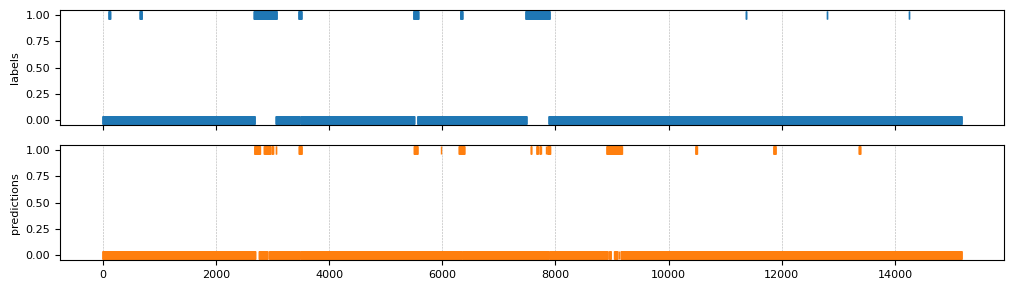

In [93]:
features_train, features_test = split_event_set(features)
_, labels_test = split_event_set(labels)

X_train, X_test, y_test = evsets_to_tabular(features_train, features_test, labels_test)

model = train(X_train)
evaluate(model, X_test, y_test, "moving statistics")

That's quite an improvement! Moving statistics can be of inmense importance in an anomaly detection setting, since "anomalous" values tend to be defined as those that don't match the item's normal behavior, and moving statistics can help the model understand what "normal behavior" means for a a specific timeframe.

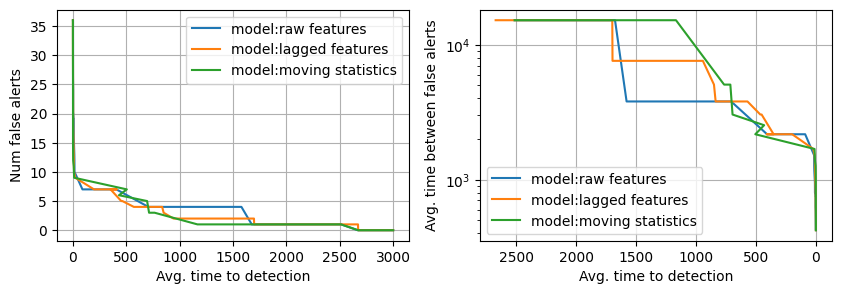

In [94]:
pred_evtset = model_prediction_to_evtset(model)
amoc_model_moving_statistics = compute_detection_amoc(pred_evtset["label"], pred_evtset["detection"])

plot_detection_amoc({
    "model:raw features": amoc_model_raw_features,
    "model:lagged features": amoc_model_lagged_features,
    "model:moving statistics": amoc_model_moving_statistics,
})

Again, as with the AUC, we see that the model with moving statistics is a bit better than the model with lagged features.

## Wrapping up

In this notebook we learned how to perform feature engineering and visualization using Temporian, applying it to a real-world anomaly detection use case.

There's some further work that could be done in this problem! Here's some ideas:
- Train a larger model! Training a larger model, on a larger dataset, would most likely yield improved results. As an example, try increasing the number of estimators in the IsolationForest (the default is 100), and optionally also increase the number of machines in each group to pull data from, and re-run the experiments!
- Use the dataset's [unlabeled train data](https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset/train) to train the model in this unsupervised manner, and then use the data we used here to test it only.
- Keep adding new features! As we demonstrated, a very simple model can go a long way if the correct features are provided to it. This is where Temporian shines - check out the full list of operators in the [API Reference](https://temporian.readthedocs.io/en/stable/reference/#operators) for some inspiration!